In [44]:
# インポート準備
import sys
sys.path.append('../')
from common.functions import *
import numpy as np

# 誤差逆伝播法

数値微分は計算に時間がかかるため、誤差逆伝播法を使う  
理解するには、「数式」と「計算グラフ」の2つのアプローチが必要。

## 計算グラフ
計算をグラフ（データの形式）で表したもの

<!-- ![](<attachment:スクリーンショット 2025-01-27 18.50.38.png>) -->

<img src="./スクリーンショット 2025-01-27 18.50.38.png" width="50%">
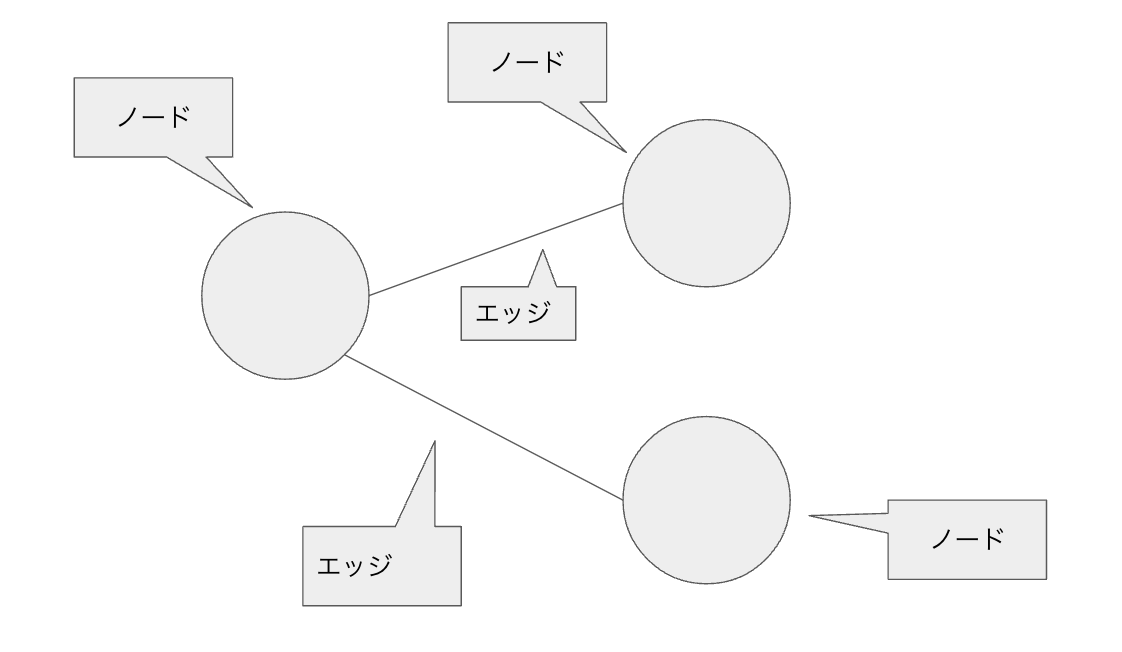


実際に簡単な問題を解いてみる。

```mermaid
graph LR
    A((りんご)) -->|100| B((✕))
    B -->|200| C((✕))
    C -->|220| D((代金))
    E((りんごの個数)) -->|2| B
    F((消費税)) -->|1.1| C
```

順伝播：左から右へ  
逆伝播：右から左へ

### 計算グラフの良いところ

- 局所的な計算ができる
  - 例）上のグラフで言うと、200円✕消費税の計算をするノードでは、なぜ200円になったかを意識しなくて良い
- 途中の計算結果を保持できる
- 逆伝播により微分を効率よく計算できる


上の例で逆伝播で微分を計算してみる

```mermaid
graph LR
    A[りんご] -->|100| B[✕]
    B -->|200| C[✕]
    C -->|220| D[代金L]
    E[りんごの個数] -->|2| B
    F[消費税] -->|1.1| C

    D -->|dL/dy = 1| C
    C -->|dL/d200 = 2.2| B
    B -->|dL/dりんご単体の値段 = 220| A
```

図の右から左までの逆伝播で求められるもの  
= りんごの値段に関する支払金額の微分  
= りんごの少しの値上がりが、最終的な金額がどれくらい上がるか。


連鎖率でだんだんに微分していっているイメージ

In [43]:

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

## Affineレイヤ
カメラライブラリ OpenCVのアフィン変換と

伝播するのが、スカラ値でなく行列になった。  


アフィンレイヤのバイアスに対する勾配 $\frac{\partial L}{\partial b}$  
バイアスの勾配は、出力の勾配 $\frac{\partial L}{\partial y}$ をそのまま伝播させるだけです。  
これは、バイアスが入力に対して直接加算されるためです。

具体的には、バイアスの勾配は以下のように計算されます。

$$ \frac{\partial L}{\partial b} = \sum_{i=1}^{N} \frac{\partial L}{\partial y_i} $$

In [35]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out


    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [36]:
import numpy as np

x = np.array([
        [
            [1, 2],
            [3, 4]
        ],
        [
            [1, 2],
            [3, 4]
        ]
    ])
print(x.shape)  # 2*2*2
original_x_shape = x.shape
x = x.reshape(x.shape[0], -1)
# -1は残りの次元数を指定する
# つまり、8/2で、x = x.reshape(2, 4)　と同じ
x.shape

(2, 2, 2)


(2, 4)

## Soft-with-Lossレイヤ
3章で、softmax関数はニューラルネットワークで使わないと言っていたのは、  
あくまで、答えを一つだけ出したい推論時には、スコアの最大値をアフィンレイヤのスコア最大値に着目すればよいから必要ないという話だった。  
ニューラルネットワークの学習時には必要となる。

■交差エントロピー誤差を使う理由
softmax関数の損失関数として使うと、逆伝播がきれいな状態になるため（出力と正解の差）。

softmax-with-lossレイヤの実装

In [37]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = functions.softmax(x)
        self.loss = functions.cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

バッチサイズで割ることでデータ一個あたりの誤差が前レイヤへ伝播する  

使ってみる

In [38]:
# 入力データと教師データ
x = np.array([[0.3, 2.9, 4.0], [0.1, 0.2, 0.7]])
t = np.array([[0, 0, 1], [0, 1, 0]])

# SoftmaxWithLossクラスのインスタンスを作成
loss_layer = SoftmaxWithLoss()

# 順伝播
loss = loss_layer.forward(x, t)
print("Loss:", loss)

print('--------------------')
print(f'y-t:\n{loss_layer.y - loss_layer.t}')

# 逆伝播
dout = 1
dx = loss_layer.backward(dout)
print('--------------------')
print("dx = (y-t)/バッチサイズ:\n", dx)

Loss: 0.7868317613004097
--------------------
y-t:
[[ 0.01821127  0.24519181 -0.26340309]
 [ 0.25462853 -0.71859196  0.46396343]]
--------------------
dx = (y-t)/バッチサイズ:
 [[ 0.00910564  0.12259591 -0.13170154]
 [ 0.12731426 -0.35929598  0.23198171]]


バッチサイズで割るところを、あとで数式にしてみる

## 誤差逆伝播法の実装

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    # 認識結果を得る処理
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        # ワンホットエンコーディングであったら1次元のクラスラベルの配列に変換する
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # 重みパラメータに対する勾配を数値微分によって求める
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    # 勾配を誤差逆伝播法によって求める処理
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

レイヤを正しい順番に連結し呼び出すだけで、  
簡単にニューラルネットワークを構築できた。

## 誤差逆伝播法の勾配確認

In [49]:
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:4.3958823593699496e-10
b1:2.5471690804246704e-09
W2:6.572229120010986e-09
b2:1.4027314505782318e-07


In [48]:
x = np.array([1, 2, 3])
print(x[:1])

[1]


## 誤差逆伝播法を使った学習

In [58]:
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
print(f'train_size:{train_size}')
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 誤差逆伝播法によって勾配を求める
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    print(f'grad:{grad['W1'].shape}')

    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

train_size:60000
grad:(784, 50)
0.17405 0.1781
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(784, 50)
grad:(78